Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.
Data description

There are 3 types of input features:

    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.


All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

## Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
import pandas as pd
import numpy as np

#Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Import plotting modules
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

You will use the seaborn library for visual analysis, so let's set that up too

In [2]:
#Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook",
    font_scale = 1.5,
    rc = {
        "figure.figsize" : (11,8),
        "axes.titlesize" : 18
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
df = pd.read_csv('mlbootcamp5_train.csv',  sep = ";")
print('Data size: ', df.shape)
df.head()

Data size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.

Let's convert the data into long format and depict the value counts of the categorical features using factorplot().

melt()  is useful to massage a DataFrame into a format where one or more columns are identifier variables, while all other columns, considered measured variables, are unpivoted to the row axis, leaving just two non-identifier columns, variable and value

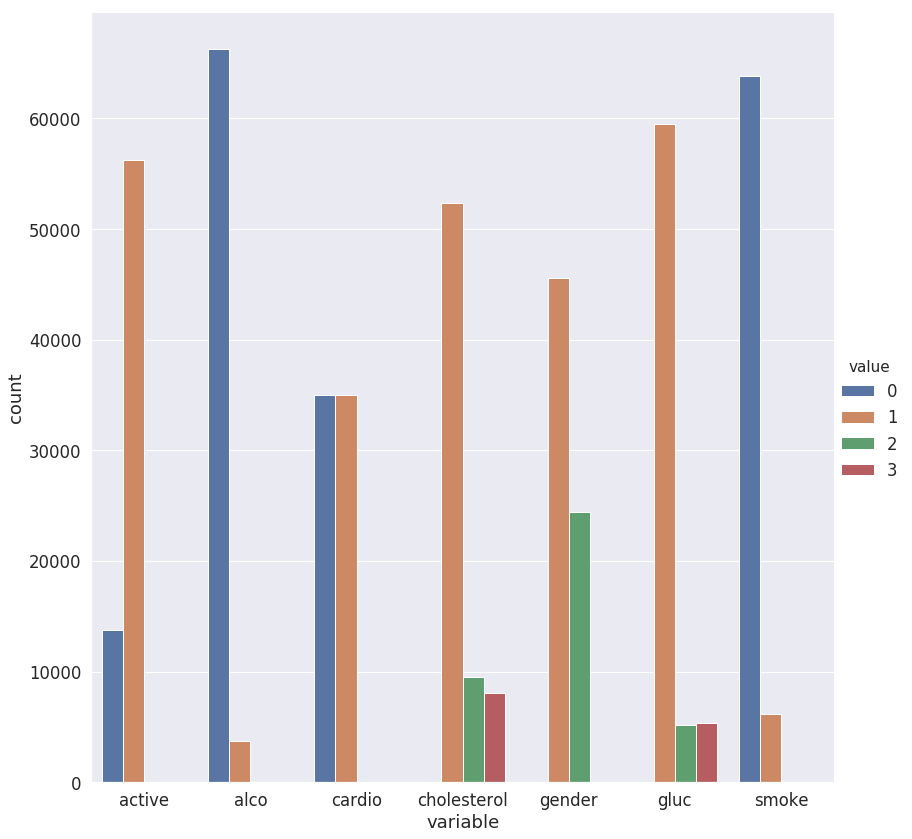

In [4]:
df_uniques = pd.melt(frame = df, value_vars = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'])

df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value'])['value'].count())\
                .sort_index(level = [0,1])\
                .rename(columns = {'value': 'count'})\
                .reset_index()
sns.factorplot(x = 'variable', y = 'count', hue = 'value', data = df_uniques, kind = 'bar', size = 12);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

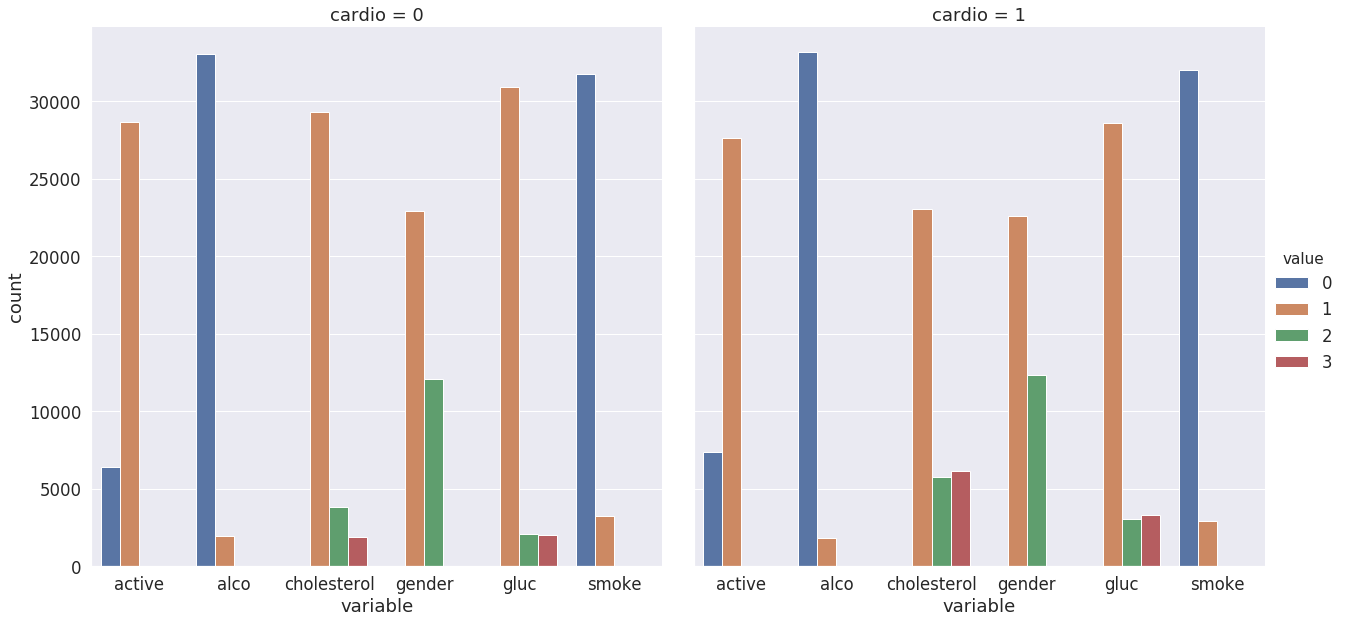

In [5]:
df_uniques = pd.melt(frame = df, value_vars = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'], id_vars = ['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 'cardio'])['value'].count())\
                .sort_index(level = [0,1])\
                .rename(columns = {'value': 'count'}) \
                .reset_index()
sns.factorplot(x = 'variable', y = 'count', hue = 'value', col = 'cardio', data = df_uniques, kind = 'bar', size = 9);

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10*'-')    

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding id);
- 7 categorical features;
- 70000 records in total.

### 1.1. Basic observations

**Question 1.1. (1 point).** How many men and women are present in this dataset? Values of the gender feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average. 

In [7]:
df.groupby('gender')['height'].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

**Answer:** 
1. 45530 women and 24470 men

**Question 1.2. (1 point).** Who more often report consuming alcohol - men or women?

In [8]:
df.groupby(['gender'])[['alco']].mean()

,alco
gender,
1,0.025500
2,0.106375


**Question 1.3. (1 point).** What is the difference between the percentages of smokers among men and women (rounded)?

Al usar cualquiera de las dos opciones de abajo, estoy sacando el porcentaje de la poblacion en general con dichas caracteristicas

In [9]:
df.groupby('gender')['smoke'].value_counts()

gender  smoke
1       0        44717
        1          813
2       0        19114
        1         5356
Name: smoke, dtype: int64

Si se aplica count nos entrega solo la cuenta de cada genero

In [10]:
df.groupby('gender')['smoke'].count()

gender
1    45530
2    24470
Name: smoke, dtype: int64

In [11]:
(pd.crosstab(df.gender, df.smoke))*100/len(df.gender)

smoke,0,1
gender,,
1,63.881429,1.161429
2,27.305714,7.651429


Lo que se pide es sacar el porcentaje de cada sub poblacion (dado el genero) y hacer la substraccion
Se usa la media ya que toma en cuenta los valores 1 los suma (que es como contabilizar los casos positivos) y los divide entre el tamaño de cada sub poblacion

In [12]:
round(df.groupby('gender')['smoke'].mean()*100,2)

gender
1     1.79
2    21.89
Name: smoke, dtype: float64

**Question 1.4. (1 point).** What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of feature age in this dataset.

In [13]:
df.groupby('smoke')['age'].median()/365.25

smoke
0    53.995893
1    52.361396
Name: age, dtype: float64

Median age of smokers is 52.4 years, for non-smokers it's 54. We see that the correct answer is 20 months. But here is a way to calculate it exactly:

In [14]:
(df[df['smoke'] == 0]['age'].median() - 
 df[df['smoke'] == 1]['age'].median()) / 365.25 * 12

19.613963039014372

### 1.2. Risk maps
#### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is: 
Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:

Calculate age_years feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
 Cholesterol level categories differ between the figure and our dataset. The conversion for the cholesterol feature is as follows: 4 mmol/l →1, 5-7 mmol/l → 2, 8 mmol/l → 3.

**Question 1.5. (2 points).** Calculate fractions of ill people (with CVD) in two segments described above. What's the quotient of these two fractions?

In [10]:
df['ageYears'] = (df.age/365.25).round().astype(int) #convert to int to use this value in a countplot figure

In [11]:
df['ageYears'].max()

65

The oldest people in the sample are aged 65. Coincidence? Don't think so!

Let's select smoking men of age [60,64]

In [17]:
smokingOldMen = df[(df['gender'] == 2) &(df['ageYears']>=60) & (df['ageYears'] < 65) & (df['smoke'] == 1)]

In [18]:
smokingOldMen

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ageYears
19,29,21755,2,162,56.0,120,70,1,1,1,0,1,0,60.0
38,52,23388,2,162,72.0,130,80,1,1,1,0,1,1,64.0
67,90,22099,2,171,97.0,150,100,3,1,1,0,1,1,61.0
177,240,21848,2,170,69.0,120,80,1,1,1,1,1,0,60.0
182,248,22671,2,174,74.0,130,80,3,1,1,0,1,1,62.0
230,318,23376,2,175,75.0,180,100,3,1,1,1,1,1,64.0
297,410,22415,2,173,70.0,130,70,2,1,1,1,1,0,61.0
327,456,22583,2,170,65.5,150,80,1,1,1,0,1,1,62.0
407,581,23262,2,162,70.0,130,70,1,1,1,1,1,1,64.0
425,606,22577,2,182,91.0,120,80,1,1,1,0,1,0,62.0


If cholesterol level in this age group is 1, and systolic pressure is below 120, then the proportion of people with CVD is 26%.

In [19]:
sChCardOMen1 = smokingOldMen[(smokingOldMen['cholesterol']==1)  & (smokingOldMen['ap_hi'] < 120)].cardio.mean()
print(sChCardOMen1)

0.263157894737


If, however, cholesterol level in this age group is 3, and systolic pressure is from 160 to 180, then the proportion of people with a CVD is 86%.

In [20]:
sChCardOMen2 = smokingOldMen[(smokingOldMen['cholesterol']==1)  & (smokingOldMen['ap_hi'] >= 160)].cardio.mean()
print(sChCardOMen2)

0.859375


As a result, the difference is approximately 3-fold. Not 5-fold, as the SCORE scale tells us, but it's possible that the SCORE risk of CVD is nonlinearly dependent on the proportion of ill people in the given age group.

In [21]:
sChCardOMen2/sChCardOMen1

3.265625


### 1.3. Analyzing BMI
#### Task:

Create a new feature – BMI (Body Mass Index). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25.

In [22]:
df['bmi'] = df['weight']/np.square(df['height']/100)

In [23]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ageYears,bmi
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0,23.011177
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60.0,29.384676
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,61.0,37.729725
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1,62.0,29.983588
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0,48.0,28.440955
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0,54.0,25.282570


**Question 1.6. (2 points).** Choose the correct statements:

1. Median BMI in the sample is within the range of normal BMI values.

In [24]:
df['bmi'].median()

26.374068120774975

In [25]:
18.5<(df['bmi'].median())<25

False

2. The BMI for women is on average higher than for men.

In [26]:
df.groupby('gender')['bmi'].median()

gender
1    26.709402
2    25.910684
Name: bmi, dtype: float64

In [27]:
(df[(df['gender']==1)]['bmi'].median()) > df[(df['gender']==2)]['bmi'].median()

True

3. Healthy people have, on average, a higher BMI than the people with CVD.

In [28]:
df.groupby(['gender','alco', 'cardio', 'smoke'])['bmi'].median().to_frame()

bmi
gender alco cardio smoke           
1      0    0      0      25.654372
                   1      25.951557
            1      0      27.852008
                   1      29.065744
       1    0      0      28.172396
                   1      26.271057
            1      0      30.110991
                   1      30.103822
2      0    0      0      25.059307
                   1      25.249337
            1      0      26.643599
                   1      27.005131
       1    0      0      26.142688
                   1      25.102391
            1      0      28.354222
                   1      26.964197

4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

Comparing BMI values in rows where alco=0 and cardio=0 we see that the last statement is correct.


### 1.4. Cleaning data

#### Task:

We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic
- height is strictly less than 2.5 percentile (Use pd.Series.quantile to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.


In [29]:
df_filtered = df[(df['ap_lo'] <= df['ap_hi']) & (df.height.quantile(0.025) <= df.height) &
                                                (df.height <= df.height.quantile(0.975)) &
                                                 (df.weight.quantile(0.025) <= df.weight) &
                                                 (df.weight <= df.weight.quantile(0.975))]

**Question 1.7. (2 points).** What percent of the original data (rounded) did we throw away?

In [30]:
100- np.round((df_filtered.shape[0]/df.shape[0])*100,0)

10.0

We've thrown out about 10% of the original data.

### Part 2. Visual data analysis
#### 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).
Task:

Plot a correlation matrix using heatmap(). You can create the matrix using the standard pandas tools with the default parameters.


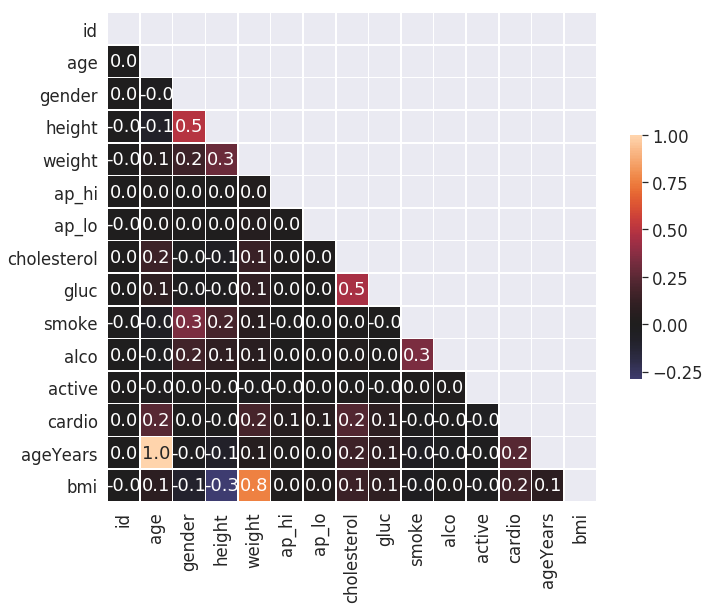

In [31]:
#calculate correlation and plot
corr = df.corr(method = 'pearson')

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the gender feature?

Height, Smoke

### 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values 1 and 2. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

**Task:**

Create a violin plot for the height and gender using violinplot(). Use the parameters:

- hue to split by gender;
- scale to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your DataFrame to *long* format using the melt() function from pandas. Here is [an example](https://stackoverflow.com/questions/41573283/seaborn-violin-plot-with-one-data-per-column/41575149#41575149) of this for your reference.


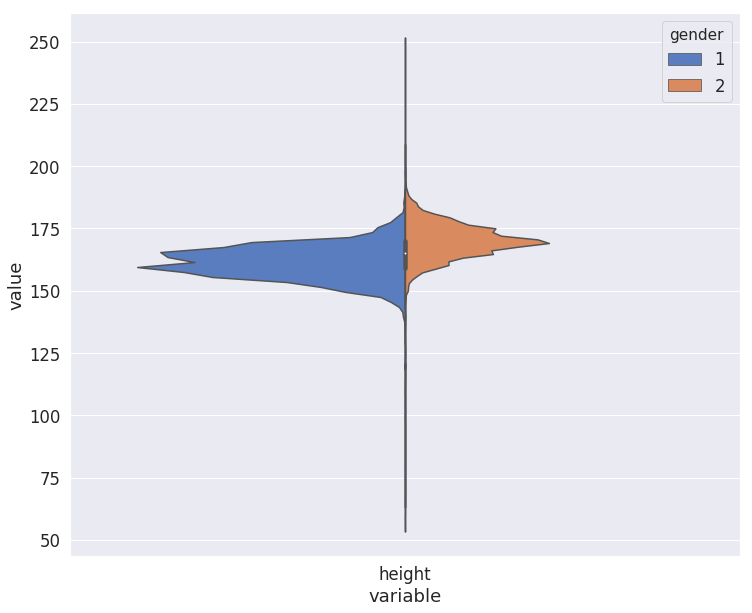

In [36]:
df_melt = pd.melt(frame=df, value_vars=['height'], id_vars=['gender'])

plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    palette="muted", 
    split=True, 
    data=df_melt, 
    scale='count',
    scale_hue=False
)

**Task:**

Create two kdeplots of the height feature for each gender on the same chart. You will see the difference between the genders more clearly, but you will be unable to evaluate the number of records in each of them.

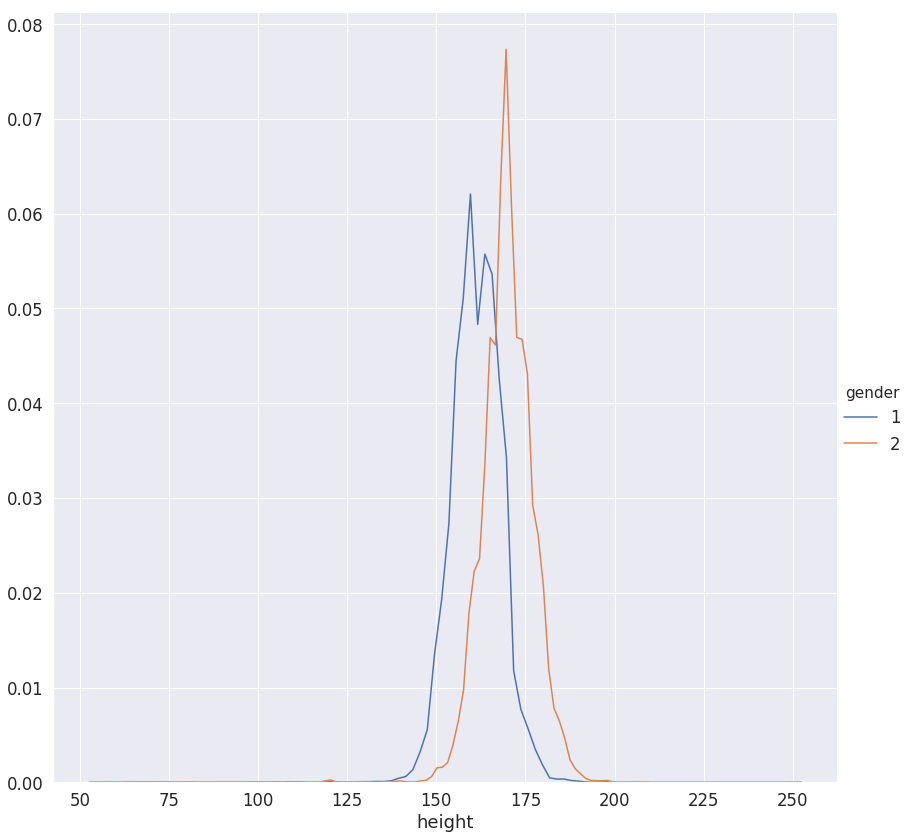

In [38]:
sns.FacetGrid(df, hue = 'gender', size = 12).map(sns.kdeplot, 'height').add_legend();

### 2.3. Rank correlation

In most cases, *the Pearson coefficient of linear correlation* is more than enough to discover patterns in data. But let's go a little further and calculate a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

**Task:**

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

In statistics, a rank correlation is any of several statistics that measure an ordinal association—the relationship between rankings of different ordinal variables or different rankings of the same variable, where a "ranking" is the assignment of the ordering labels "first", "second", "third", etc. to different observations of a particular variable. A rank correlation coefficient measures the degree of similarity between two rankings, and can be used to assess the significance of the relation between them. 

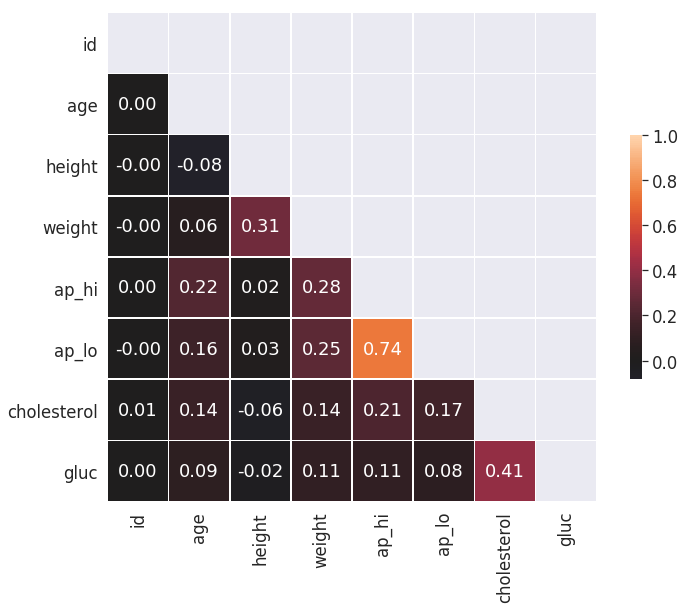

In [8]:
corr= df[['id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']].corr(method = 'spearman')
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?
5. Ap_hi, Ap_lo

**Question 2.3. (1 point).** Why does these features have strong rank correlation?
3. Data nature


### 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.
Task:

Create a count plot using countplot() with the age on the X axis and the number of people on the Y axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each cardio class of that age.


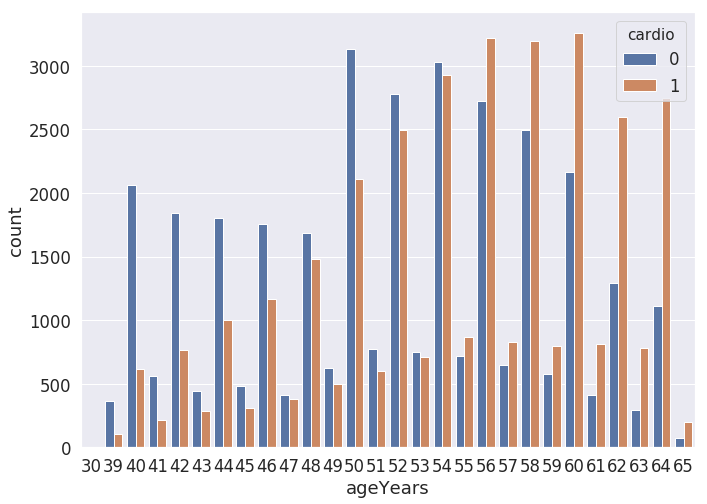

In [12]:
sns.countplot(x = 'ageYears', hue = 'cardio', data = df);

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

2. 55